IMPORT LIBRARIES

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


LOAD DATASET

In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
data = pd.read_csv('/content/drive/MyDrive/xai/Darknet/Darknet.csv')

In [116]:
import pandas as pd

nan_rows = data[data.isnull().any(axis=1)]

# To get the count of rows with NaN values
count_nan_rows = nan_rows.shape[0]

print(f"Number of rows with NaN values: {count_nan_rows}")

Number of rows with NaN values: 47


In [117]:
# To identify which columns have NaN values
columns_with_nan = data.columns[data.isnull().any()].tolist()
print(f"Columns with NaN values: {columns_with_nan}")

Columns with NaN values: ['Flow Bytes/s']


DATA PREPARATION AND PREPROCESSING

In [118]:
data.shape

(141530, 85)

In [119]:
data['Label'].value_counts()

Label
Non-Tor    93356
NonVPN     23863
VPN        22919
Tor         1392
Name: count, dtype: int64

In [120]:
#dropping invalid columns
data = data.drop(['Flow ID','Src IP','Dst IP','Timestamp'],axis=1)

In [121]:
data.shape

(141530, 81)

In [122]:
data['Label'].unique()

array(['Non-Tor', 'NonVPN', 'Tor', 'VPN'], dtype=object)

In [123]:
data = data.drop(['Label.1'],axis=1)

In [124]:
# Replace infinity values with NaN in training and testing sets
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with class-wise means
class_column = 'Label'

# Calculate class-wise means
class_means = data.groupby(class_column).transform(lambda x: x.fillna(x.mean()))

# Fill NaN values with class-wise means
data = data.fillna(class_means)

In [125]:
#label encoding categorical variable
encoder = LabelEncoder()
data.Label = encoder.fit_transform(data.Label)
data.Label

0         0
1         0
2         0
3         0
4         0
         ..
141525    3
141526    3
141527    3
141528    3
141529    3
Name: Label, Length: 141530, dtype: int64

In [126]:
#split the dataset into independent and dependent variables
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [127]:
X.head()


,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,57158,443,6,229,1,1,0,0,0,0,...,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00
1,57159,443,6,407,1,1,0,0,0,0,...,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00
2,57160,443,6,431,1,1,0,0,0,0,...,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00
3,49134,443,6,359,1,1,0,0,0,0,...,0,20,0,0,0,0,0.000000e+00,0.000,0.000000e+00,0.000000e+00
4,34697,19305,6,10778451,591,400,64530,6659,131,0,...,581,20,0,0,0,0,1.437760e+15,3117718.131,1.437760e+15,1.437760e+15


In [128]:
#splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.25,random_state=10)

# **MODEL USED: DECISION TREE**

MODEL TRAINING  

In [129]:
classifier = DecisionTreeClassifier(criterion='entropy',min_samples_split=3,min_samples_leaf=1, random_state=10)
classifier.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=3,
                       random_state=10)

MODEL TESTING

In [130]:
y_pred = classifier.predict(X_test)
y_pred

array([0, 0, 3, ..., 3, 1, 1])

MODEL EVALUATION

In [131]:
#MAKING THE CONFUSION MATRIX

clf_rpt = classification_report(y_test,y_pred)
print("classification report: \n", clf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.94      0.95      0.95      6016
           2       0.94      0.90      0.92       374
           3       0.95      0.94      0.95      5760

    accuracy                           0.98     35383
   macro avg       0.96      0.95      0.95     35383
weighted avg       0.98      0.98      0.98     35383

Accuracy Score : 0.9812056637368227


In [132]:
from sklearn.metrics import f1_score


In [133]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9811914879412967

<Axes: >

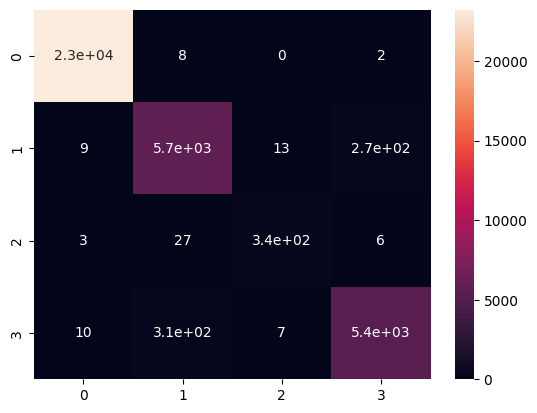

In [134]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)

DISPLAYING TREE

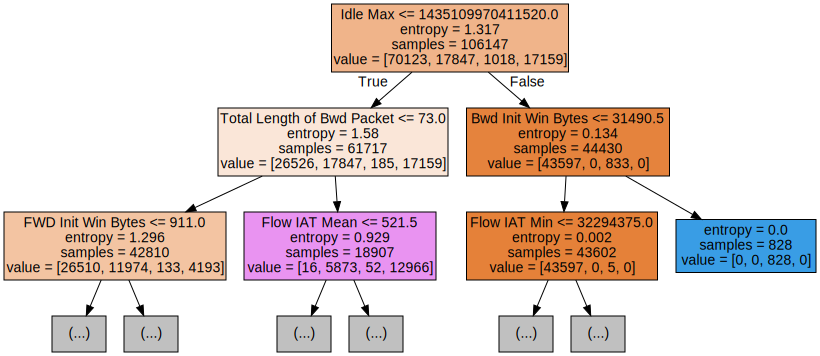

In [135]:
from sklearn import tree
import graphviz
tree_graph = tree.export_graphviz(classifier,out_file=None ,feature_names=X.columns,filled=True,max_depth=2)
graphviz.Source(tree_graph)


# **MODEL USED: RANDOM FOREST**

MODEL TRAINING

In [136]:
model_rf = RandomForestClassifier(criterion='entropy',min_samples_split=5,min_samples_leaf=2,n_estimators=200,random_state=10)

model_rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200, random_state=10)

MODEL TESTING

In [137]:
rf_prediction = model_rf.predict(X_test)
rf_prediction

array([0, 0, 3, ..., 3, 1, 1])

In [138]:
# compute prediction probabilities for sample 'x'
predict_rf = lambda x: model_rf.predict_proba(x).astype(float)

MODEL EVALUATION

In [139]:
rf_rpt = classification_report(y_test,rf_prediction)
print("classification report: \n", rf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,rf_prediction))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.95      0.97      0.96      6016
           2       0.99      0.86      0.92       374
           3       0.97      0.95      0.96      5760

    accuracy                           0.98     35383
   macro avg       0.98      0.95      0.96     35383
weighted avg       0.98      0.98      0.98     35383

Accuracy Score : 0.9845123364327502


In [140]:
from sklearn.metrics import f1_score


In [141]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,rf_prediction, average='weighted')
f1_weighted

0.984475623785766

<Axes: >

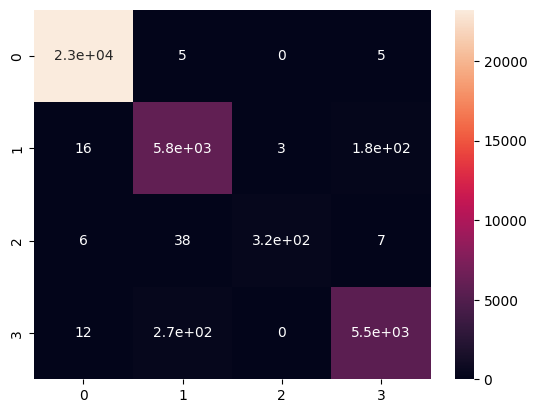

In [142]:
rf_cm = confusion_matrix(y_test, rf_prediction)
sns.heatmap(rf_cm, annot = True)

# **MODEL USED: SVM**

In [143]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_n = sc.fit_transform(X_train)
X_test_n = sc.transform(X_test)

In [144]:
from sklearn.svm import SVC

MODEL TRAINING

In [ ]:
svc=SVC(probability=True,kernel='rbf',gamma=2)
svc.fit(X_train_n, y_train)

MODEL TESTING

In [ ]:
y_pred = svc.predict(X_test_n)
y_pred

In [ ]:
# compute prediction probabilities for sample 'x'
predict_svc = lambda x: svc.predict_proba(X_test_n)

In [ ]:
type(predict_svc)

MODEL EVALUATION

In [ ]:
#MAKING THE CONFUSION MATRIX

clf_rpt = classification_report(y_test,y_pred)
print("classification report: \n", clf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

In [ ]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)

# MODEL USED: XGBOOST

MODEL TRAINING

In [152]:
from xgboost import XGBClassifier

In [153]:
xgb = XGBClassifier(random_state=10)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

MODEL TESTING

In [154]:
y_pred=xgb.predict(X_test)
y_pred

array([0, 0, 3, ..., 3, 1, 1])

In [155]:
# Make predictions and measure prediction time per sample
import time
start_time = time.time()
y_pred = xgb.predict(X_test)
end_time = time.time()

# Calculate the prediction time per sample
total_samples = len(X_test)
prediction_time_per_sample = (end_time - start_time) / total_samples

print(f"Total prediction time: {end_time - start_time} seconds")
print(f"Prediction time per sample: {prediction_time_per_sample} seconds")

Total prediction time: 0.3342578411102295 seconds
Prediction time per sample: 9.446848517938826e-06 seconds


In [156]:
predict_xgb = lambda x: xgb.predict_proba(x).astype(float)

MODEL EVALUATION

In [157]:
#MAKING THE CONFUSION MATRIX

clf_rpt = classification_report(y_test,y_pred)
print("classification report: \n", clf_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.95      0.98      0.96      6016
           2       0.99      0.92      0.95       374
           3       0.98      0.95      0.96      5760

    accuracy                           0.99     35383
   macro avg       0.98      0.96      0.97     35383
weighted avg       0.99      0.99      0.99     35383

Accuracy Score : 0.9871124551338213


In [158]:
from sklearn.metrics import f1_score

# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9871005516667765

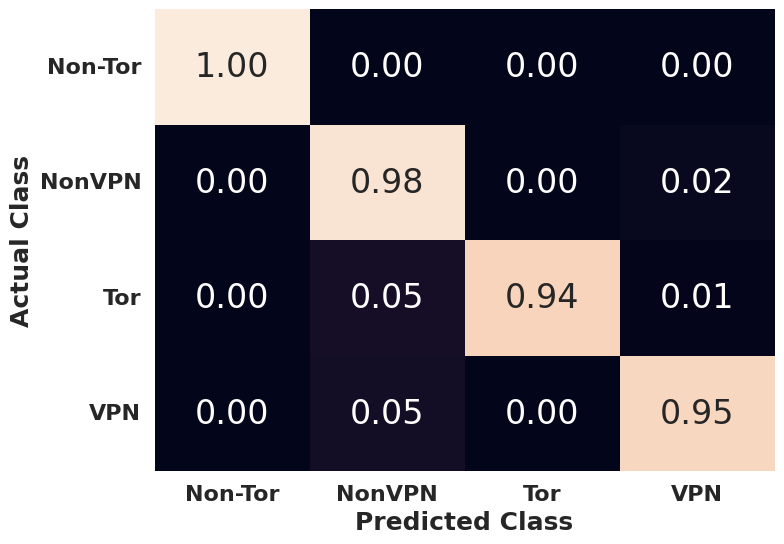

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# Replace class_labels with the actual class labels in your problem
class_labels = ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to represent probabilities
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]

# Create a DataFrame from the normalized confusion matrix
cm_df = pd.DataFrame(cm_normalized, index=class_labels, columns=class_labels)
# Increase font size
sns.set(font_scale=2)
# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cm_df, annot=True, fmt='.2f', cbar=False)

# Customize x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=16, fontweight='bold')
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=16, fontweight='bold')

# Customize labels and title
plt.xlabel('Predicted Class',fontsize=18, fontweight='bold')
plt.ylabel('Actual Class',fontsize=18, fontweight='bold')

# Show the plot
plt.show()


MODEL INTERPRETATION USING ELI5

In [ ]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=3544196d870e585b793662086f5e51bd2a0128ae984b3e188b6399c40acc923d
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
import eli5 as eli
from eli5.sklearn import PermutationImportance

In [ ]:
eli.explain_weights(xgb)

Weight,Feature
0.2785,Fwd Act Data Pkts
0.2218,Bwd Packet Length Min
0.0828,Fwd Seg Size Min
0.0560,Idle Max
0.0357,Subflow Fwd Bytes
0.0339,FWD Init Win Bytes
0.0328,Flow IAT Std
0.0244,Fwd Packet Length Min
0.0216,Packet Length Max
0.0194,Fwd Packet Length Mean


In [ ]:
# Imporatant features from Test data
perm = PermutationImportance(xgb).fit(X_test,y_test)

In [ ]:
eli.show_weights(perm,feature_names=X_test.columns.tolist())

Weight,Feature
0.1139 ± 0.0019,Idle Max
0.0965 ± 0.0020,FWD Init Win Bytes
0.0396 ± 0.0016,Fwd Seg Size Min
0.0140 ± 0.0006,Dst Port
0.0063 ± 0.0005,Bwd Packets/s
0.0054 ± 0.0003,Src Port
0.0045 ± 0.0003,Bwd Init Win Bytes
0.0042 ± 0.0010,Flow IAT Min
0.0031 ± 0.0003,Subflow Fwd Bytes
0.0031 ± 0.0008,Bwd Packet Length Min


MODEL INTERPRETATION USING SHAP

In [ ]:
pip install shap==0.43.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.3 MB/s eta 0:00:00


[04:25:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


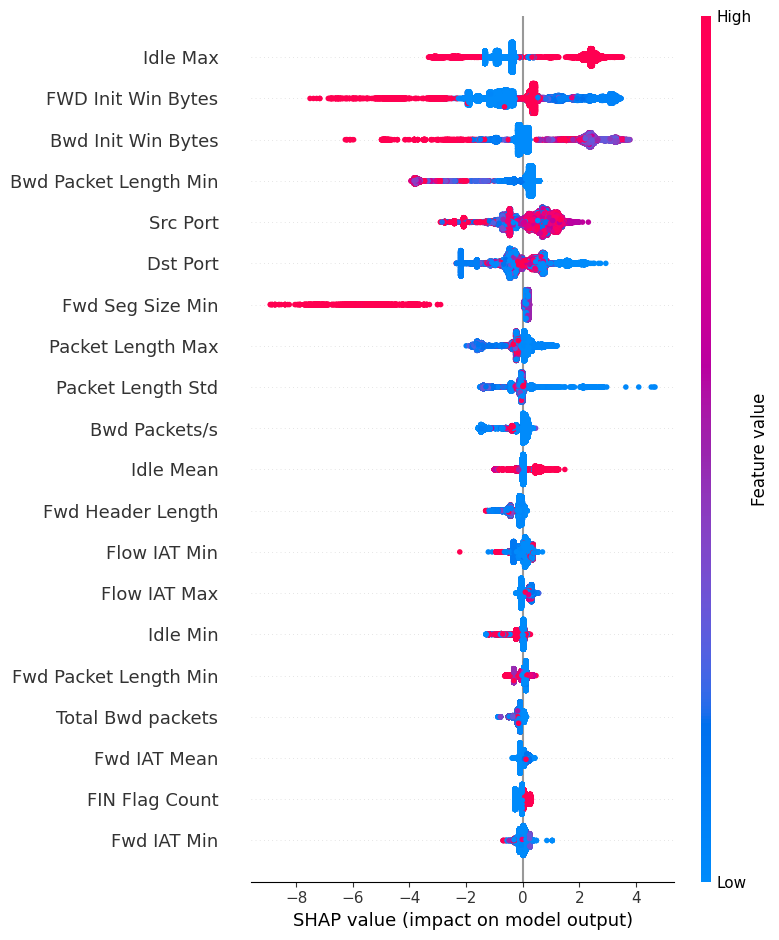

In [ ]:
import shap
shap.initjs()
#define a tree explainer for the model built
xgb_explainer_1 = shap.TreeExplainer(xgb)
shap_values = xgb_explainer_1.shap_values(X_test)
shap.summary_plot(shap_values[0],X_test,feature_names=X.columns)

FixedFormatter should only be used together with FixedLocator
The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.


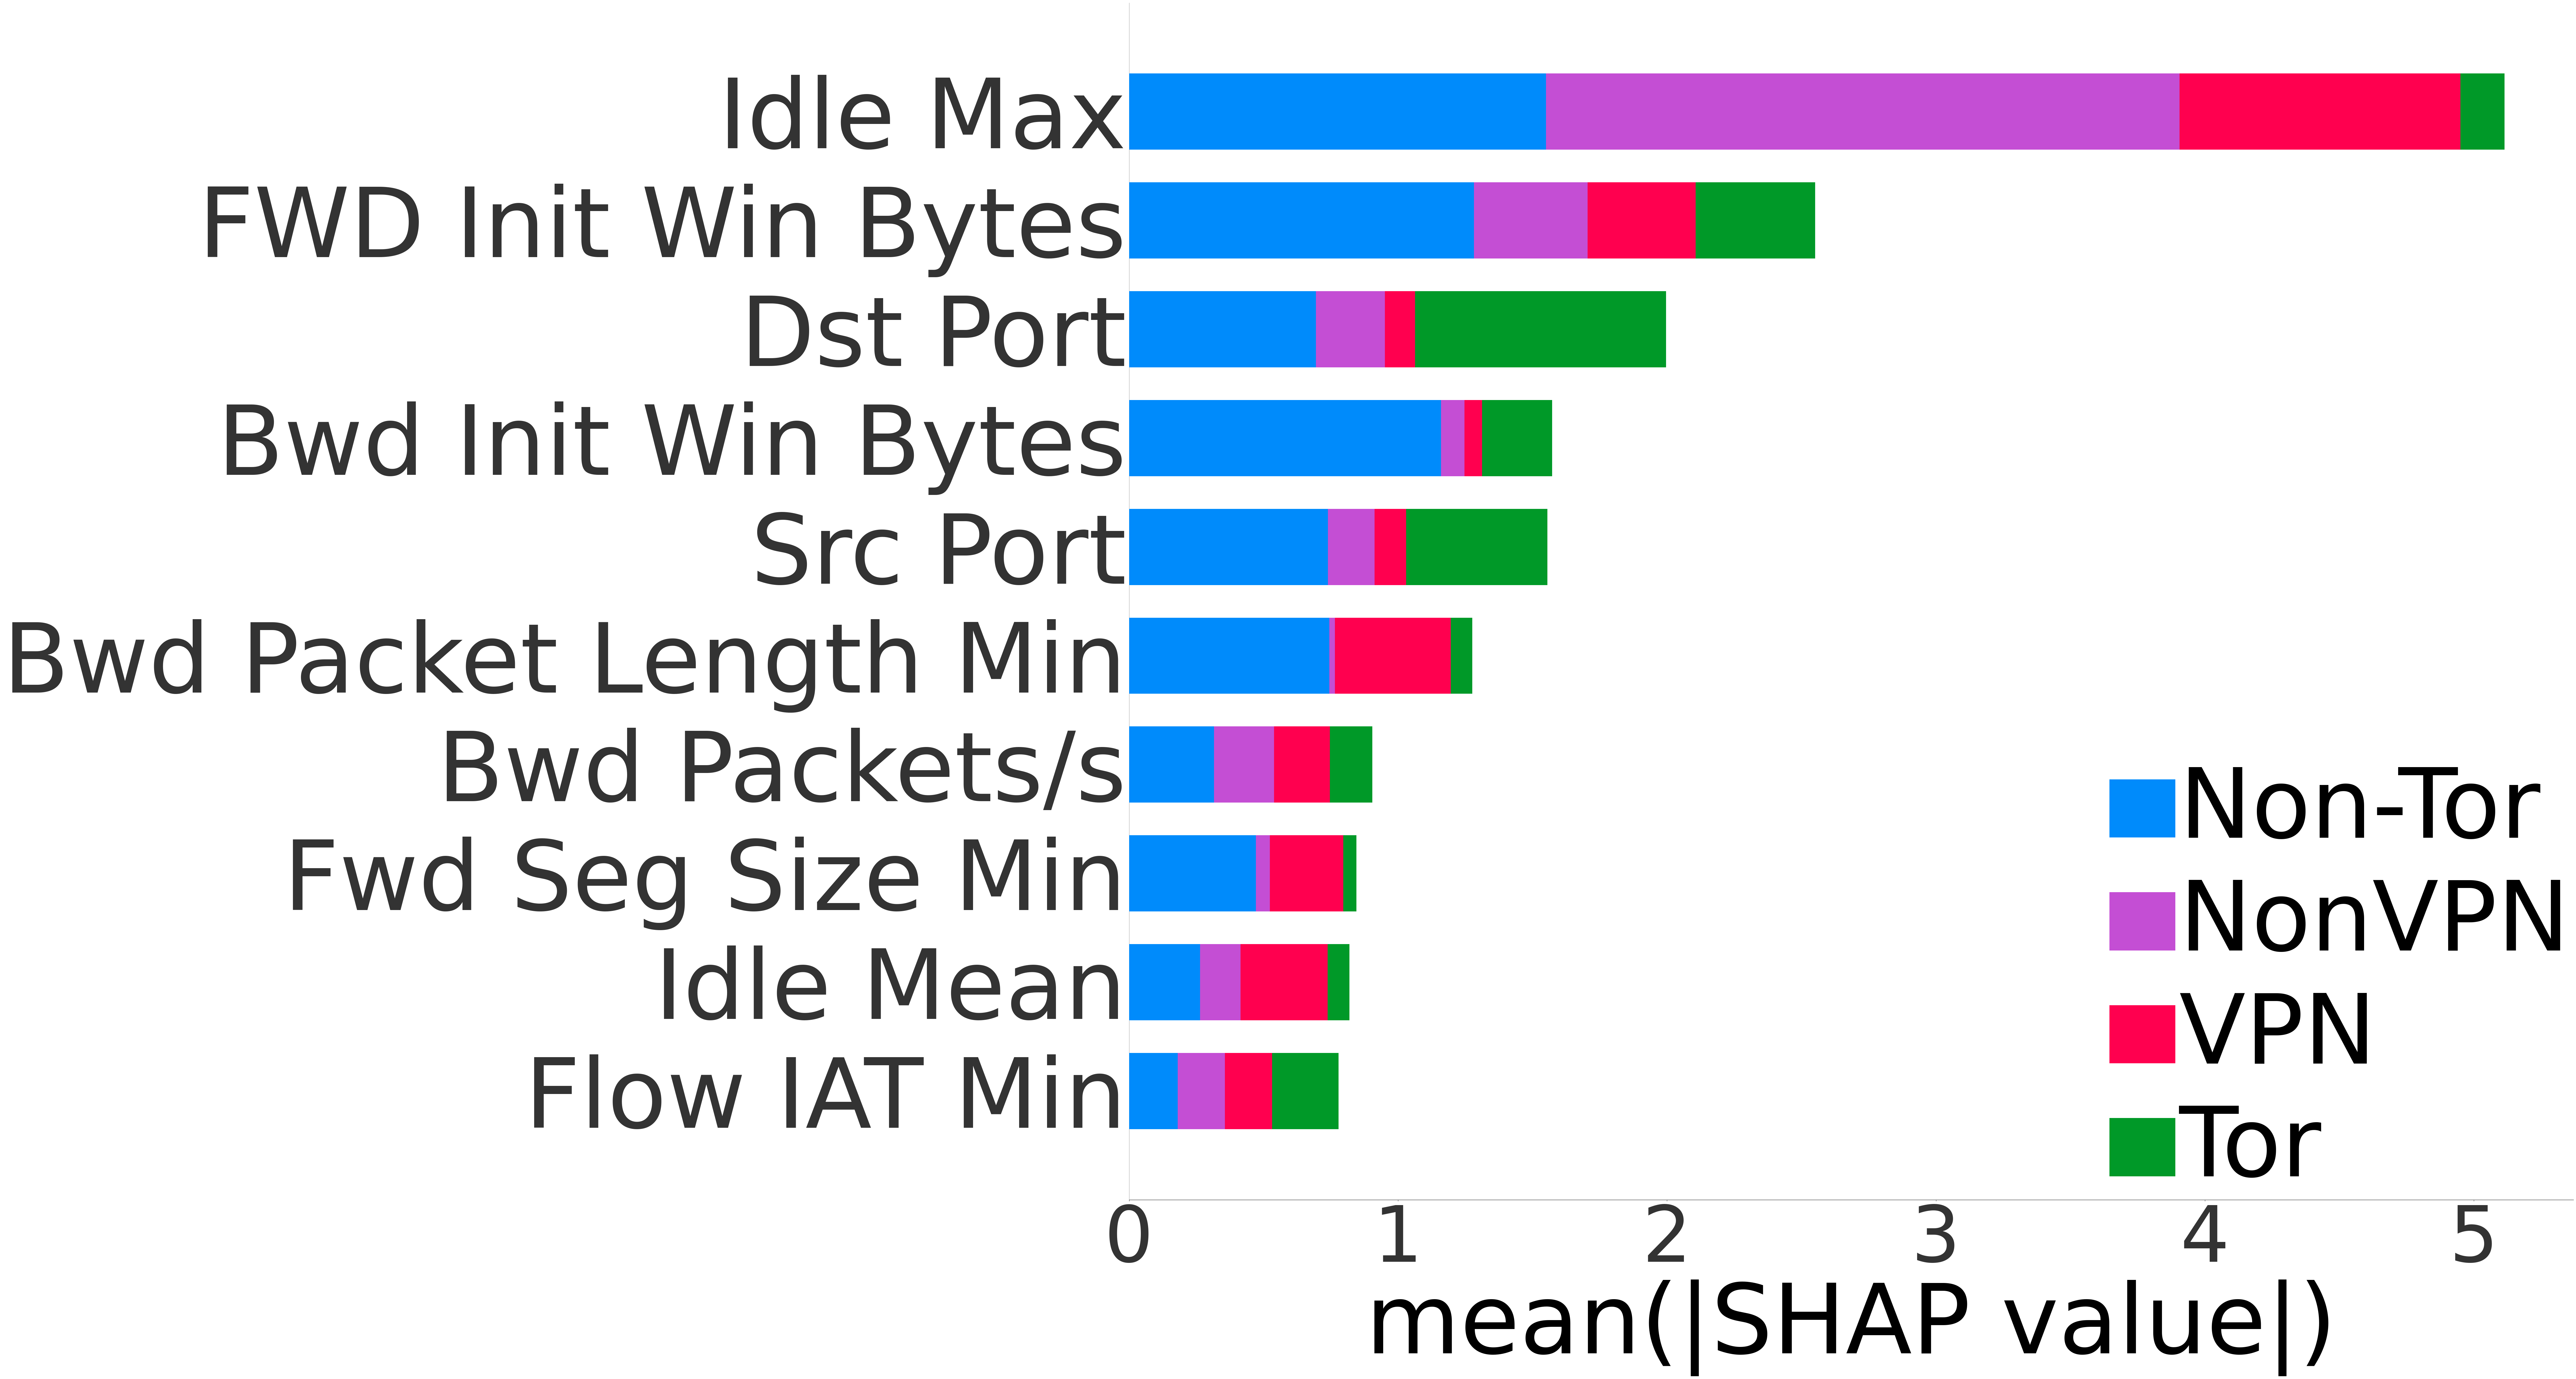

In [ ]:

fig = plt.figure()
shap.summary_plot(shap_values,X_test,class_names=['Non-Tor', 'NonVPN', 'Tor', 'VPN'],max_display=10,show=False)
# Set the size of the figure
plt.gcf().set_size_inches(75, 50)  # Adjust the width and height as per your preference
# Adjust the font size of the tick labels
plt.xticks(fontsize=250)  # Adjust the font size as needed
plt.yticks(fontsize=250)  # Adjust the font size as needed
# Adjust the font size of the x-axis label
plt.xlabel("mean(|SHAP value|)", fontsize=250)  # Adjust the font size as needed
# Adjust the font size of the Shap values

plt.gca().set_xticklabels(plt.gca().get_xticklabels(), fontsize=200)  # Adjust the font size as needed

plt.legend(labelspacing=5,handletextpad=16,frameon=False)
# Adjust the font size of the legend
legend = plt.gca().get_legend()

# Set the font size for the legend labels
for text in legend.get_texts():
    text.set_fontsize(250)  # Adjust the font size as needed

# Set the color box height and width
for handle in legend.legendHandles:
    handle.set_height(150)  # Adjust the height as needed
    handle.set_width(170)   # Adjust the width as needed



# Save the figure in EPS format
plt.savefig('Summary_Darknet.eps', format='eps', bbox_inches='tight', dpi=500)
plt.show()

[2.619474, 0.18486461, -3.0496535, 0.14760467]
0


<Figure size 640x480 with 0 Axes>

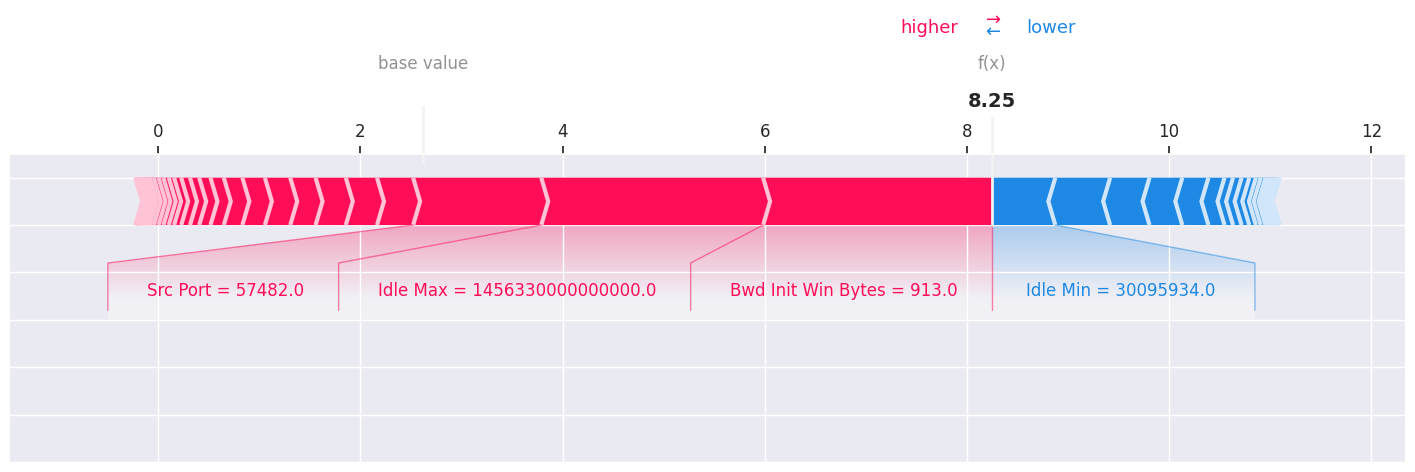

In [ ]:
import shap
import matplotlib.pyplot as plt

# JavaScript visualization initialization
shap.initjs()

# Example data
i = 1
print(xgb_explainer_1.expected_value)
instance = X_test.iloc[[i]]

# Print predicted values
p = xgb.predict(instance)
print(p[0])

# Increase font size using rcParams
plt.rcParams.update({'font.size': 20})

# Create SHAP force plot
fig = plt.figure()
shap.force_plot(xgb_explainer_1.expected_value[p[0]], shap_values[p[0]][i], X_test.iloc[[i]], matplotlib=True, feature_names=X.columns, figsize=(18, 4))

plt.show()


MODEL INTERPRETATION USING LIME

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=4f21a18c234af2ff6c12ec77fa8fd19e066380f156bdda830f5457acfc45bd54
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
from lime import lime_tabular

In [ ]:
X1 = X_train.values

In [ ]:
chosen_instance = X_test.iloc[1]

In [ ]:
xgb_explainer_2 = lime.lime_tabular.LimeTabularExplainer(X1,feature_names=X_train.columns,class_names =['Non-Tor', 'NonVPN', 'Tor', 'VPN'])

In [ ]:
exp = xgb_explainer_2.explain_instance(chosen_instance,predict_xgb,top_labels=1,num_features=10)


In [ ]:
exp.show_in_notebook(show_all=False)

Counterfactual Explanation

In [ ]:
!pip install dice_ml

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/xai/Darknet/Darknet.csv')

data.replace([np.inf, -np.inf], np.nan, inplace=True)

data=data.dropna()

data = data.drop(['Flow ID','Src IP','Dst IP','Timestamp'],axis=1)
data = data.drop(['Label.1'],axis=1)

encoder = LabelEncoder()
data.Label = encoder.fit_transform(data.Label)
data.Label

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

train_dataset, test_dataset,y_train,y_test = train_test_split(data,y ,test_size=0.2, random_state=42,stratify=y)
x_train=train_dataset.drop("Label",axis=1)
x_test=test_dataset.drop("Label",axis=1)

In [ ]:
x_train = x_train.values
x_test = x_test.values

In [ ]:
#counterfactual explanation
import dice_ml
d= dice_ml.Data(dataframe=train_dataset,continuous_features=['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
       'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg',
       'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg',
       'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg',
       'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets',
       'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes',
       'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std',
       'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max',
       'Idle Min'],outcome_name="Label") # class label is mandatory in the dataset
m=dice_ml.Model(model=xgb,backend="sklearn")
exp =  dice_ml.Dice(d,m,method="random")


/usr/local/lib/python3.10/dist-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


In [ ]:
y_test[0:1]

136632    3
Name: Label, dtype: int64

In [ ]:
e=exp.generate_counterfactuals(X_test[10:11],total_CFs=5,desired_class=3)# deciding which feature to vary
e.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:09<00:00,  9.50s/it]

Query instance (original outcome : 1)


,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,53958,5355,17,420717,2,0,44,0,22,22,...,8,0,0,0,0,0.0,0.0,0.0,0.0,1



Diverse Counterfactual set (new outcome: 3)


,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,-,-,-,-,-,-,-,-,-,-,...,44.0,-,-,-,-,-,-,-,-,3.0
1,-,-,-,-,-,-,-,-,-,-,...,44.0,-,-,-,-,-,-,-,-,3.0
2,-,-,-,92234724.0,-,-,-,-,-,-,...,-,-,-,-,-,-,-,1437866345431039.8,-,3.0
3,-,-,-,-,-,-,-,-,-,-,...,44.0,-,-,-,-,-,-,144303178841517.0,-,3.0
4,-,-,-,-,-,-,-,-,-,-,...,38.0,-,-,-,-,-,-,-,-,3.0


# **MODEL USED: Multi-Layer Perceptron**

Model Training

In [167]:
from sklearn.neural_network import MLPClassifier

In [168]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_n = sc.fit_transform(X_train)
X_test_n = sc.transform(X_test)

In [169]:
mlp = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation = 'relu',solver='adam',random_state=20)

In [170]:
mlp.fit(X_train_n, y_train)

MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=300, random_state=20)

Model Prediction

In [171]:
#Predicting y for X_val
y_pred = mlp.predict(X_test_n)

Model Evaluation

In [172]:
#MAKING THE CONFUSION MATRIX

mlp_rpt = classification_report(y_test,y_pred)
print("classification report: \n", mlp_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.91      0.93      0.92      6016
           2       0.97      0.85      0.91       374
           3       0.93      0.91      0.92      5760

    accuracy                           0.97     35383
   macro avg       0.95      0.92      0.94     35383
weighted avg       0.97      0.97      0.97     35383

Accuracy Score : 0.9708334510923324


In [173]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9707816602587354

<Axes: >

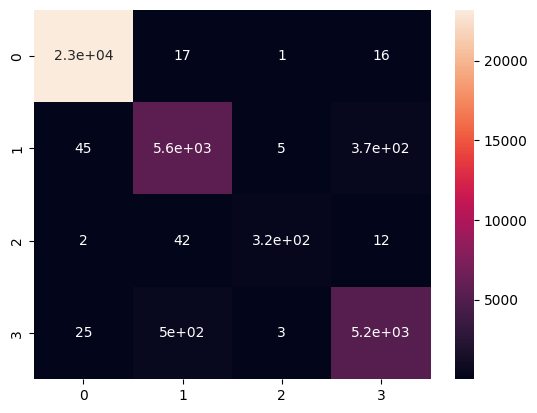

In [174]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)

# **MODEL USED : LIGHT GRADIENT BOOST (LGB)**

In [160]:
from lightgbm import LGBMClassifier

In [161]:
lgb = LGBMClassifier(num_iterations=200, tree_learner='serial',num_leaves=10)
lgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13890
[LightGBM] [Info] Number of data points in the train set: 106147, number of used features: 64
[LightGBM] [Info] Start training from score -0.414574
[LightGBM] [Info] Start training from score -1.782989
[LightGBM] [Info] Start training from score -4.646985
[LightGBM] [Info] Start training from score -1.822302


LGBMClassifier(num_iterations=200, num_leaves=10, tree_learner='serial')

In [162]:
y_pred=lgb.predict(X_test)
y_pred

array([0, 0, 3, ..., 3, 1, 1])

In [163]:
predict_lgb = lambda x: lgb.predict_proba(x).astype(float)

In [164]:
#MAKING THE CONFUSION MATRIX

lgb_rpt = classification_report(y_test,y_pred)
print("classification report: \n", lgb_rpt)
print("Accuracy Score :" ,accuracy_score(y_test,y_pred))

classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     23233
           1       0.95      0.97      0.96      6016
           2       0.99      0.91      0.94       374
           3       0.97      0.95      0.96      5760

    accuracy                           0.99     35383
   macro avg       0.98      0.96      0.97     35383
weighted avg       0.99      0.99      0.99     35383

Accuracy Score : 0.9855297741853433


In [165]:
# Replace 'y_true' and 'y_pred' with your actual and predicted labels
f1_weighted = f1_score(y_test,y_pred, average='weighted')
f1_weighted

0.9855158190568533

<Axes: >

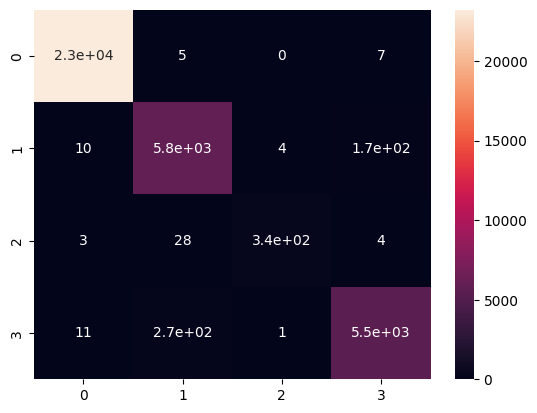

In [166]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True)